# GloVe
In this notebook we are going to explain the concepts and use of word embeddings in NLP, using Glove as en example. Then we will try to apply the pre-trained Glove word embeddings to solve a text classification problem using this technique.

## Large Movie Review Dataset
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.

Link to dataset: http://ai.stanford.edu/~amaas/data/sentiment/

Publications Using the Dataset:

_Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)_.

## Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

%matplotlib inline

#Import module to split the datasets
from sklearn.model_selection import train_test_split
# Import modules to evaluate the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc

We set the variables for data location.



In [2]:
# Global parameters
#root folder
root_folder='.'
data_folder_name='data'
glove_filename='glove.6B.100d.txt'

train_filename='train.csv'
# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
glove_path = os.path.abspath(os.path.join(DATA_PATH, glove_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

#Relevant columns
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'

## Loading a pre-trained word embedding: GloVe
Files with the pre-trained vectors Glove can be found in many sites like Kaggle or in the previous link of the Stanford University. We will use the glove.6B.100d.txt file containing the glove vectors trained on the Wikipedia and GigaWord dataset.
* Glove Download:  https://nlp.stanford.edu/projects/glove/
* Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download) https://nlp.stanford.edu/data/glove.6B.zip

First we convert the GloVe file containing the word embeddings to the word2vec format for convenience of use. We can do it using the gensim library, a function called glove2word2vec.

In [3]:
# We just need to run this code once, the function glove2word2vec 
# saves the Glove embeddings in the word2vec format 
# that will be loaded in the next section
from gensim.scripts.glove2word2vec import glove2word2vec

#glove_input_file = glove_filename
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)

C:\Users\abelli\AppData\Local\Temp\ipykernel_19560\2434667283.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


(400000, 100)

So our vocabulary contains 400K words represented by a feature vector of shape 100. Now we can load the Glove embeddings in word2vec format and then analyze some analogies. In this way if we want to use a pre-trained word2vec embeddings we can simply change the filename and reuse all the code below.

In [4]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Show a word embedding
print('King: ',model.get_vector('king'))

result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print('Most similar word to King + Woman - man: ', result)

King:  [-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -

We would like extract some interesting features of our word embeddings,Now, our words are numerical vectors so we can measure and compare distances between words to show some of the properties that these embedding provide.

In [5]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print('King - Man + Woman = ',result)
result = model.most_similar(positive=['rome', 'france'], negative=['paris'], topn=1)
print('France - Paris + Rome = ',result)
result = model.most_similar(positive=['english', 'france'], negative=['french'], topn=1)
print('France - french + english = ',result)
result = model.most_similar(positive=['june', 'december'], negative=['november'], topn=1)
print('December - November + June = ',result)
result = model.most_similar(positive=['sister', 'man'], negative=['woman'], topn=1)
print('Man - Woman + Sister = ',result)

King - Man + Woman =  [('queen', 0.7698540687561035)]
France - Paris + Rome =  [('italy', 0.8295994400978088)]
France - french + english =  [('england', 0.7678162455558777)]
December - November + June =  [('july', 0.9814669489860535)]
Man - Woman + Sister =  [('brother', 0.8288711905479431)]


We can observe how the word vectors include information to relate countries with nationalities, months of the year, family relationships, etc.


In [6]:
result = model.most_similar(positive=['aunt', 'nephew'], negative=['niece'], topn=1)
print('aunt - nephew + niece = ',result)

aunt - nephew + niece =  [('uncle', 0.8936851620674133)]


We can extract wich words are more similar to another word, so they all are "very close" in the vector space.

In [7]:
result = model.most_similar(positive=['spain'], topn=10)
print('10 most similar words to Spain: ',result)



10 most similar words to Spain:  [('portugal', 0.797070324420929), ('argentina', 0.7758234143257141), ('italy', 0.7746188044548035), ('france', 0.7557463645935059), ('spanish', 0.734722375869751), ('brazil', 0.724494457244873), ('mexico', 0.7206876277923584), ('madrid', 0.7078268527984619), ('morocco', 0.7001035213470459), ('netherlands', 0.6802704334259033)]


In [8]:
result = model.most_similar(positive=['football'], topn=10)
print('\n10 most similar words to Football: ',result)




10 most similar words to Football:  [('soccer', 0.8732221722602844), ('basketball', 0.8555637001991272), ('league', 0.815336287021637), ('rugby', 0.8007532954216003), ('hockey', 0.7833694815635681), ('club', 0.7730998992919922), ('team', 0.7720499634742737), ('baseball', 0.76057368516922), ('players', 0.7399718761444092), ('player', 0.7376238703727722)]


In [9]:
result = model.most_similar(positive=['doctor'], topn=10)
print('\n10 most similar words to Doctor: ',result)


10 most similar words to Doctor:  [('physician', 0.7673240303993225), ('nurse', 0.75215083360672), ('dr.', 0.7175194025039673), ('doctors', 0.7080884575843811), ('patient', 0.7074184417724609), ('medical', 0.6995992660522461), ('surgeon', 0.6905338168144226), ('hospital', 0.6900930404663086), ('psychiatrist', 0.658909797668457), ('dentist', 0.6447421312332153)]


In [10]:
#Lets show some measure of similarities between words
result = model.similar_by_word("cat")
print(" Cat is similar to {}: {:.4f}".format(*result[0]))
result = model.similar_by_word("father")
print(" Father is similar to {}: {:.4f}".format(*result[0]))

 Cat is similar to dog: 0.8798
 Father is similar to son: 0.9240


## Loading the dataset
Out IMdb reviews can be loaded from keras.dataset. But in this dataset the tokens has already been "numericalized", but we want them as plain text, so we need to reverse them to the original tokens. Then, we load the dataset, load the vocabulary and we will use the vocab to get the original token for every single token in the whole dataset.

In [24]:
!pip install tensorflow==2.3.0
!pip install keras==2.4

In [30]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=None)

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

review = [reverse_word_index.get(i-3, "") for i in train_data[0]]
review2 = [reverse_word_index.get(i-3, "") for i in train_data[0]]

In [31]:
reverse_word_index

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

In [32]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [33]:
review

['',
 'this',
 'film',
 'was',
 'just',
 'brilliant',
 'casting',
 'location',
 'scenery',
 'story',
 'direction',
 "everyone's",
 'really',
 'suited',
 'the',
 'part',
 'they',
 'played',
 'and',
 'you',
 'could',
 'just',
 'imagine',
 'being',
 'there',
 'robert',
 "redford's",
 'is',
 'an',
 'amazing',
 'actor',
 'and',
 'now',
 'the',
 'same',
 'being',
 'director',
 "norman's",
 'father',
 'came',
 'from',
 'the',
 'same',
 'scottish',
 'island',
 'as',
 'myself',
 'so',
 'i',
 'loved',
 'the',
 'fact',
 'there',
 'was',
 'a',
 'real',
 'connection',
 'with',
 'this',
 'film',
 'the',
 'witty',
 'remarks',
 'throughout',
 'the',
 'film',
 'were',
 'great',
 'it',
 'was',
 'just',
 'brilliant',
 'so',
 'much',
 'that',
 'i',
 'bought',
 'the',
 'film',
 'as',
 'soon',
 'as',
 'it',
 'was',
 'released',
 'for',
 'retail',
 'and',
 'would',
 'recommend',
 'it',
 'to',
 'everyone',
 'to',
 'watch',
 'and',
 'the',
 'fly',
 'fishing',
 'was',
 'amazing',
 'really',
 'cried',
 'at',
 't

In [35]:
print('Vocabulary lenght: ',len(word_index))
print('Review example: ',review[:20])
print('Label: ',train_labels[0])

Vocabulary lenght:  88584
Review example:  ['', 'this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', "everyone's", 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you']
Label:  1


In [36]:
# Convert the train and test dataset to strings of words
X_train=[]
for doc in train_data:
    X_train.append(' '.join([reverse_word_index.get(i - 3, "") for i in doc]))

X_test=[]
for doc in test_data:
    X_test.append(' '.join([reverse_word_index.get(i - 3, "") for i in doc]))
print(len(X_train),len(X_test))
print(X_train[0])

25000 25000
 this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing an

Applying the word embedding to a text classification task
Now, we have our word representation, a vector for every word in our vocabulary. But we need to deal with full sentences so we need to create a **sentence embedding**, basically we need a vector that represent the whole sentence and every feature in the vector will be based on the word embeddings. There are many posibilities and we are notr going to cover this topic, so we apply a very simple method: the ith value in the sentence embedding will be the mean of the ith values in the word embedding of all the words in the sentence.

We will create a class that will contain our vocabulary and glove vectors and then it will transform every review (a sentence in our example) to a vector representation as we describe previously.

In [37]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    # build your word2vec here and then use it with your transform function
    # In our case we keep the model that has been loaded with Glove
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]
    print ("shape: " + str(self.D))

    X = np.zeros((len(data), self.D))
    print ("X shape:" + str(np.shape(X)))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
        #print ("X["+str(n)+"]: shape: " +str(np.shape(X[n])))
        #print (X[n])
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

Next, we create a Vectorizer object that will help us to transform our reviews to vectors, a numerical representation. Then we can use those vectors to feed our classifier.

In [38]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = train_labels
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = test_labels

Loading in word vectors...
Finished loading in word vectors
shape: 100
X shape:(25000, 100)
Numer of samples with no words found: 0 / 25000
shape: 100
X shape:(25000, 100)
Numer of samples with no words found: 0 / 25000


In [39]:
print(Xtrain.shape,Xtest.shape)


(25000, 100) (25000, 100)


## Train a classifier on the sentence embeddings
As text classification is just a type of classification problem we can apply some of the well-known classifiers to predict the label of a text. The next cells build different models to solve our classification task.

But first we create some helper functions to plot the results:

In [41]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()
    


## A random forest classifier
First, we try with a simple model, a Random Forest. It can be considered as a baseline benchmark to any binary clasification problem.

This notebook is about word embeddings, so we are not covering or interested in building the best classifier. We want to show us how to use the embeddings in a very simple way.

In [42]:
from sklearn.ensemble import RandomForestClassifier

# create the model, train it, print scores
clf = RandomForestClassifier(n_estimators=200)

clf.fit(Xtrain, Ytrain)

print("train score:", clf.score(Xtrain, Ytrain))
print("test score:", clf.score(Xtest, Ytest))

train score: 1.0
test score: 0.76168


              precision    recall  f1-score   support

           0    0.77123   0.74408   0.75741     12500
           1    0.75278   0.77928   0.76580     12500

    accuracy                        0.76168     25000
   macro avg    0.76200   0.76168   0.76161     25000
weighted avg    0.76200   0.76168   0.76161     25000



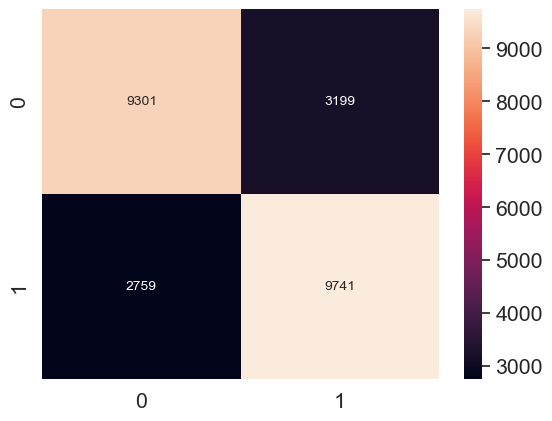

In [43]:
# Predicting the Test set results
y_pred = clf.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=5))
plot_confusion_matrix(Ytest, y_pred)


## ROC Curve
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

* True Positive Rate
* False Positive Rate

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.

![ROC](roc.png)




In [46]:
# ROC Curve
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

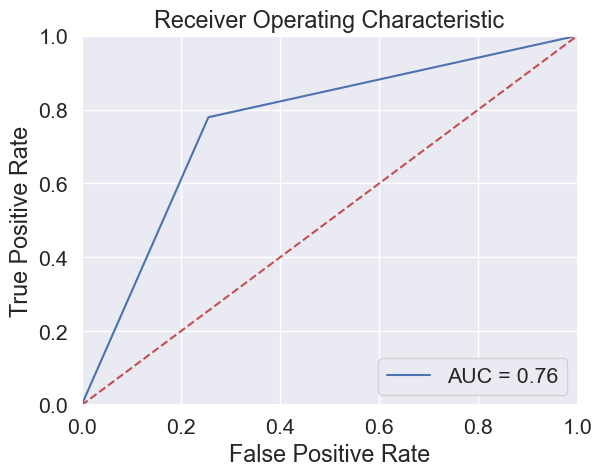

In [47]:
plot_roc_curve(Ytest, y_pred)

**AUC** stands for **Area under the ROC Curve.** That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1)